# Housing Price Prediction

# <center> Importing Libraries 

In [1]:
#Importing the basic librarires
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import warnings 
warnings.filterwarnings('ignore')

### <center> Data Inspections    

In [2]:
#Importing the dataset
df = pd.read_csv('Housing.csv')

In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
#Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
#Checking number of unique rows in each feature
df.nunique().sort_values()

mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
prefarea              2
furnishingstatus      3
bathrooms             4
stories               4
parking               4
bedrooms              6
price               219
area                284
dtype: int64

In [6]:
#Checking the stats of all the columns
display(df.describe())

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


**Inference:** The dataset reveals a diverse housing market with prices ranging from 1.75M to 13.3M and areas between 1650 sq. ft and 16200 sq. ft. Most houses have 2-3 bedrooms, 1-2 bathrooms, and limited parking, with a median of no parking. Larger homes with more amenities likely contribute to higher prices and variability in the data.

---

# <center> Exploratory Data Analysis (EDA)

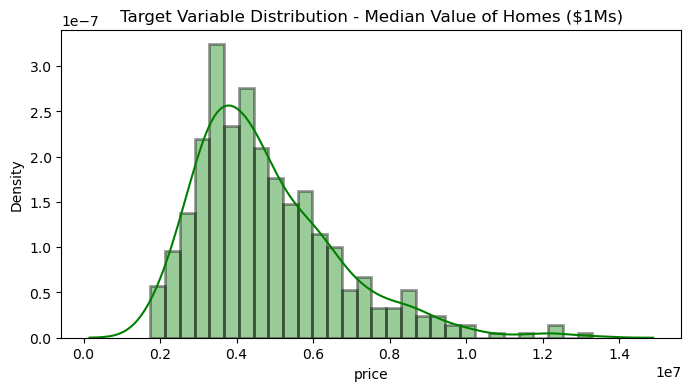

In [7]:
plt.figure(figsize=[8,4])
sns.distplot(df['price'], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

**Inference:**The Target Variable seems to be be normally distributed, averaging around 20 units.

Visualising Categorical Features:


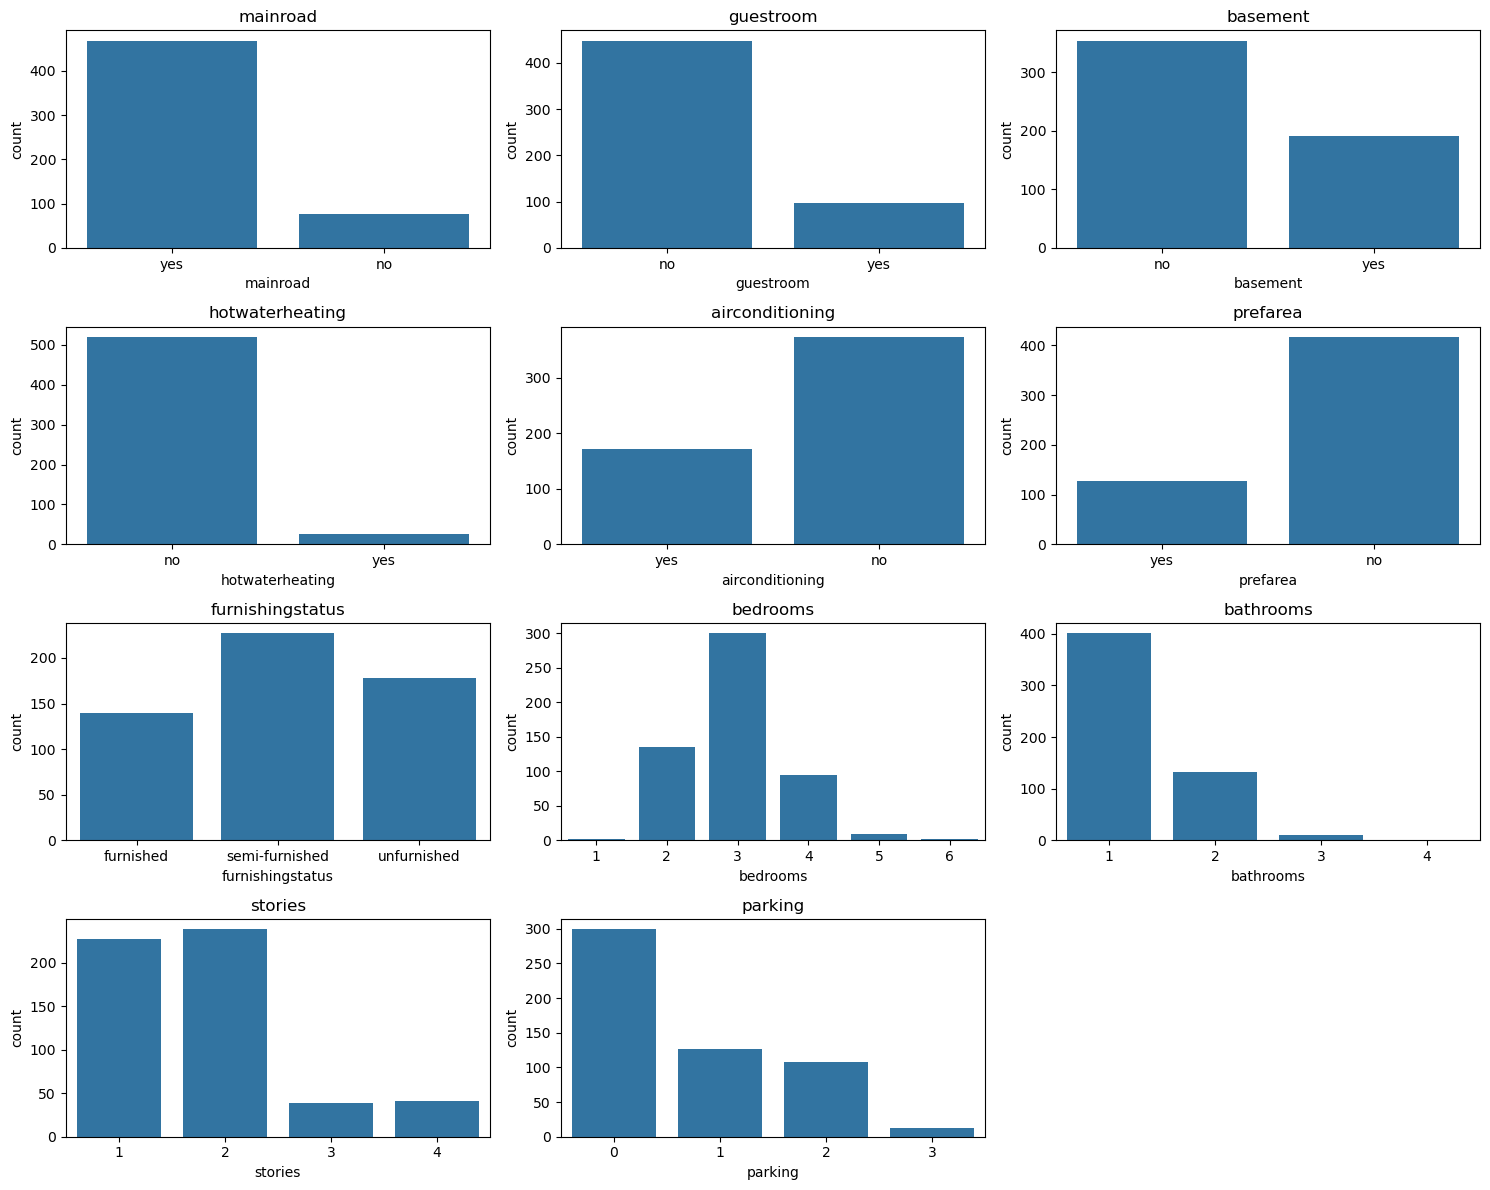

In [8]:
categorical_features = df.select_dtypes(include='object').columns.tolist()
categorical_features += [col for col in df.columns if df[col].nunique() <= 8 and col not in categorical_features]
print('Visualising Categorical Features:')

n = 3
plt.figure(figsize=[15, 3 * math.ceil(len(categorical_features) / n)])

for i in range(len(categorical_features)):
    plt.subplot(math.ceil(len(categorical_features) / n), n, i + 1)
    sns.countplot(x=df[categorical_features[i]])
    plt.title(categorical_features[i])

plt.tight_layout()
plt.show()

**Inference** Same information we saw in the summary statistics above

Numeric Features Distribution:


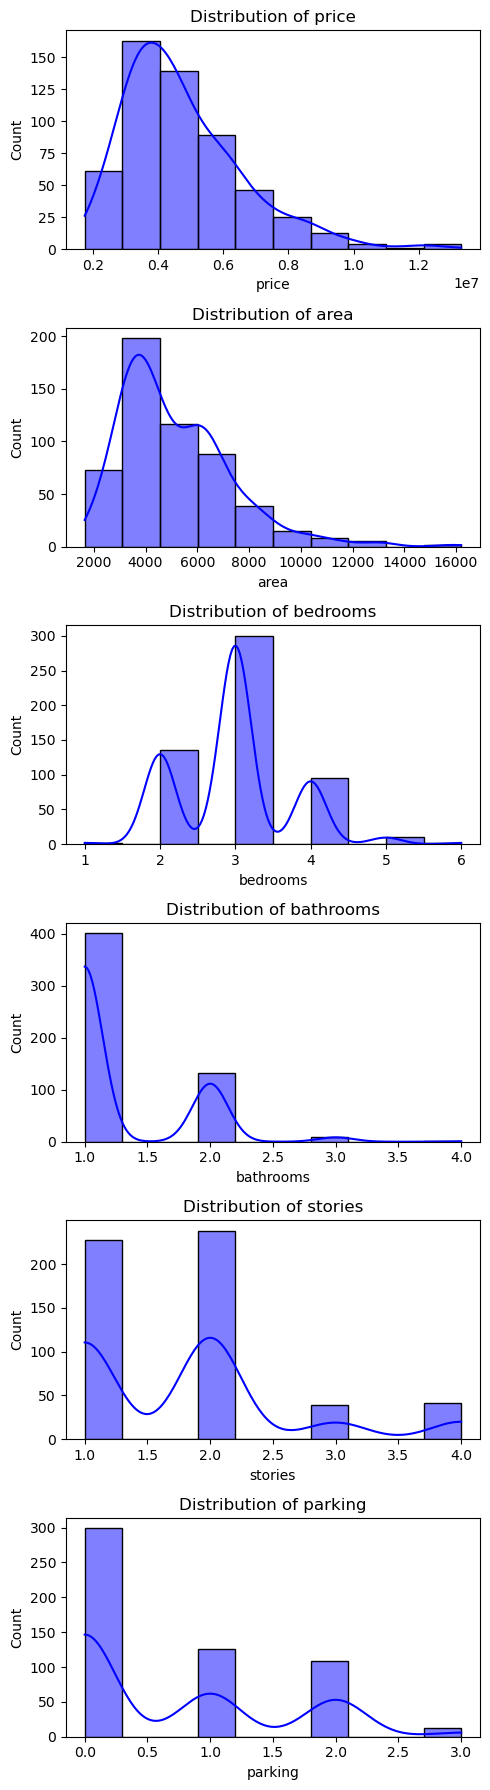

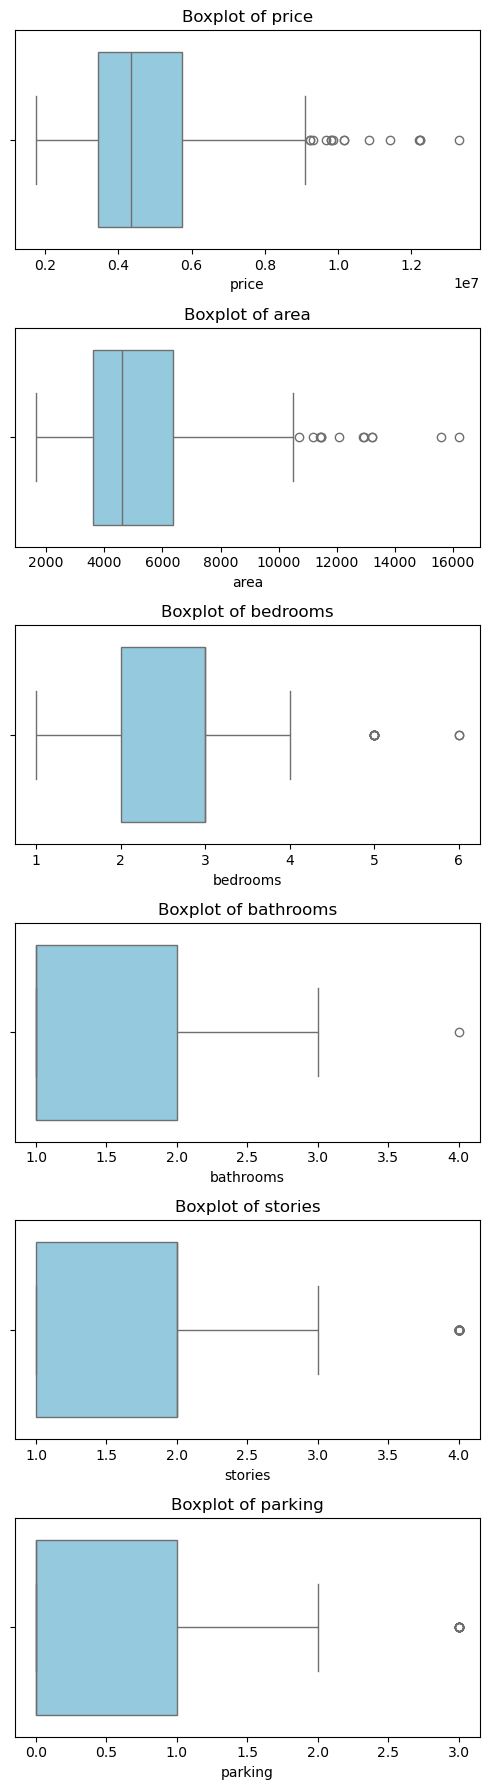

In [9]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Numeric Features Distribution:')

plt.figure(figsize=(5, len(numerical_features) * 3))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.histplot(df[feature], kde=True, bins=10, color='blue', edgecolor="black")
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()
plt.figure(figsize=(5, len(numerical_features) * 3))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

**Inference:** There seem to be some outliers. let us fix these in the upcoming section...

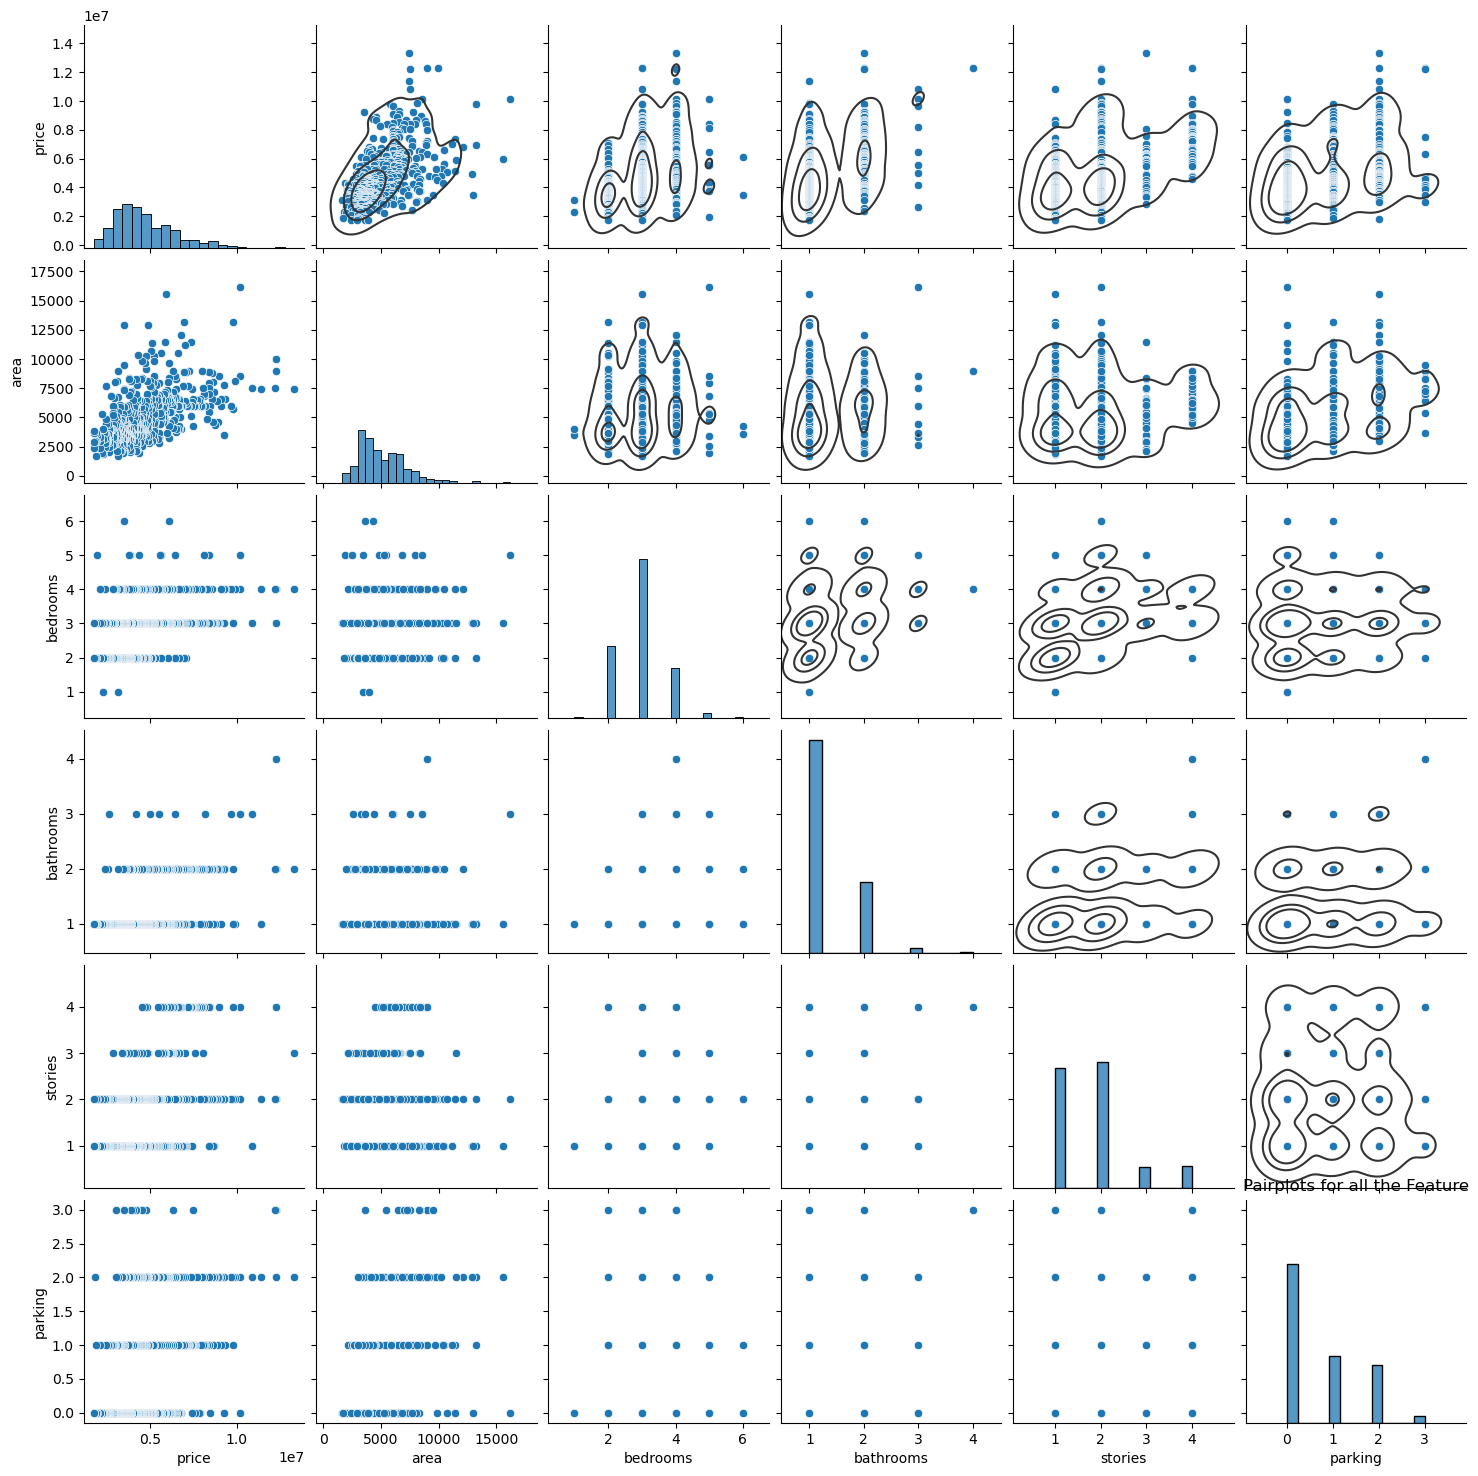

In [10]:
g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

**Inference:** The pair plot shows that price is closely linked to the area of a property, while the number of bedrooms, bathrooms, stories, and parking spaces are somewhat related to both area and price, with some patterns appearing in these features.

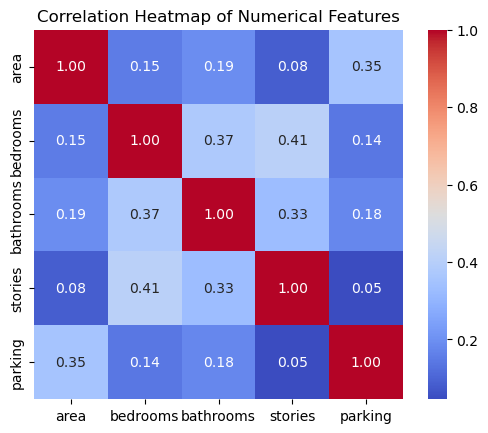

In [11]:
numerical_features = df.select_dtypes(include=['int64']).drop(columns=['price'])
correlation_matrix = numerical_features.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

The heatmap reveals strong positive correlations between a property's area and its number of bedrooms, bathrooms, and parking spaces. This means that larger properties tend to have more of these features. There is also a moderate positive correlation between the number of bedrooms and bathrooms. The number of stories in a house, however, doesn't seem to have a strong relationship with these other features.

In [12]:
import plotly.express as px
import plotly.graph_objects as go

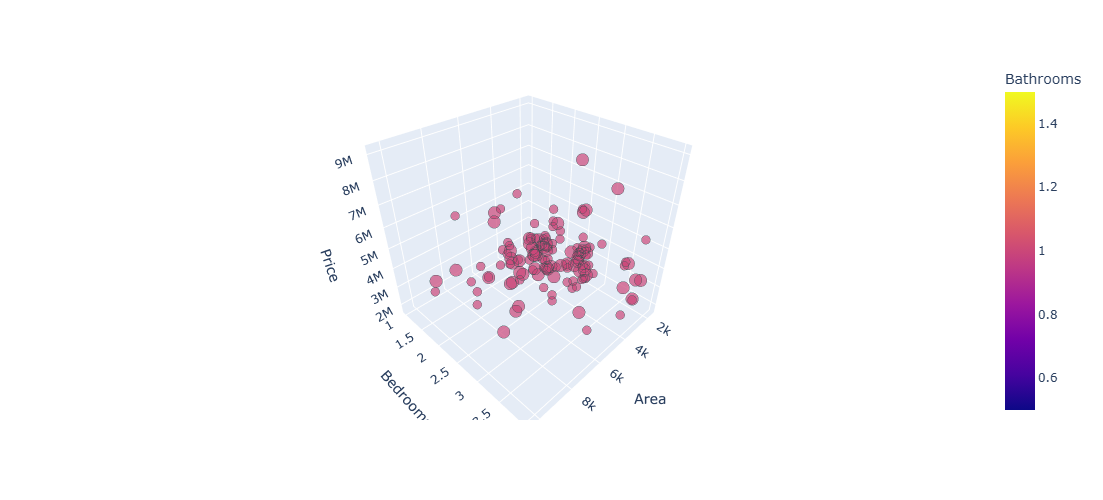

In [38]:
fig = px.scatter_3d(
    df,
    x="area",               
    y="bedrooms",            
    z="price",              
    color="bathrooms", 
    size="parking",        
    hover_data=["mainroad", "guestroom", "basement", "hotwaterheating", 
                "airconditioning", "stories", "prefarea", "furnishingstatus"], 
    labels={
        'price': 'Price', 
        'area': 'Area', 
        'bedrooms': 'Bedrooms',
        'bathrooms': 'Bathrooms',
        'stories': 'Stories',
        'mainroad': 'Main Road', 
        'guestroom': 'Guest Room',
        'basement': 'Basement', 
        'hotwaterheating': 'Hot Water Heating',
        'airconditioning': 'Air Conditioning',
        'parking': 'Parking', 
        'prefarea': 'Preferred Area', 
        'furnishingstatus': 'Furnishing Status'
    },
    width=600,              
    height=500,              
)

fig.update_traces(
    marker={"line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

fig.show()


---

# <center> Data Preprocessing

In [14]:
#Removal of any Duplicate rows
counter = 0
rs,cs = df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print(f"The dataset doesn't have any duplicates")
else:
    print(f'Number of duplicates dropped {rs-df.shape[0]}')

The dataset doesn't have any duplicates


In [15]:
#Checking for empty elements
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
price                             0         0.0
area                              0         0.0
bedrooms                          0         0.0
bathrooms                         0         0.0
stories                           0         0.0
mainroad                          0         0.0
guestroom                         0         0.0
basement                          0         0.0
hotwaterheating                   0         0.0
airconditioning                   0         0.0
parking                           0         0.0
prefarea                          0         0.0
furnishingstatus                  0         0.0


The datset doesn't have any inconsistant values.

In [16]:
# Removal of outlier:
features1 = [i for i in df.select_dtypes(include=['int64']).columns]

for i in features1:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df = df[df[i] <= (Q3 + 1.5 * IQR)]
    df = df[df[i] >= (Q1 - 1.5 * IQR)]
    df = df.reset_index(drop=True)

display(df.head())

print('After removal of outliers, The dataset now has {} samples.'.format(df.shape[0]))

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,9100000,6000,4,1,2,yes,no,yes,no,no,2,no,semi-furnished
1,8750000,4320,3,1,2,yes,no,yes,yes,no,2,no,semi-furnished
2,8645000,8050,3,1,1,yes,yes,yes,no,yes,1,no,furnished
3,8400000,8875,3,1,1,yes,no,no,no,no,1,no,semi-furnished
4,7875000,6550,3,1,2,yes,no,yes,no,yes,0,yes,furnished


After removal of outliers, The dataset now has 365 samples.


---

# <center> Baseline Model Development

In [17]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [18]:
target = "price"
feature = ['area', 'bedrooms', 'bathrooms',
            'stories', 'mainroad',
            'guestroom', 'basement',
            'hotwaterheating',
            'airconditioning',
            'parking',
            'prefarea',
            'furnishingstatus']
X_train = df[feature]
y_train = df[target]

In [19]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apartment price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apartment price: 4045012.33
Baseline MAE: 973692.8279226872


The average apartment price in the dataset is ₦4,045,012.33. Using this as a baseline prediction for all apartments, the model's error is, on average, ₦973,692.83.

This means that if we predict every apartment's price as the average, our predictions will typically be off by nearly ₦1 million. Any advanced model we build should aim to have a lower error than this baseline to be considered effective.

In [20]:
# Instantiating a one hot encoder for categorical features
categorical_features = X_train[['mainroad', 'guestroom', 'basement', 
                                 'hotwaterheating', 'airconditioning', 
                                 'prefarea', 'furnishingstatus']]

numerical_features = X_train[['area', 'bedrooms', 
                              'bathrooms', 
                              'stories', 
                              'parking']]

ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(categorical_features)
XT_train = ohe.transform(categorical_features) 


In [21]:
class ProportionalCategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing values in categorical columns based on the proportion of observed categories.
    """
    def fit(self, X, y=None):
        # Calculating value proportions for each categorical column
        self.category_proportions_ = {
            col: X[col].value_counts(normalize=True)
            for col in X.select_dtypes(include='object').columns
        }
        return self

    def transform(self, X):
        X = X.copy()
        for col, proportions in self.category_proportions_.items():
            missing_mask = X[col].isnull()
            X.loc[missing_mask, col] = np.random.choice(
                proportions.index,
                size=missing_mask.sum(),
                p=proportions.values
            )
        return X


class ProportionalNumericalImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing values in numerical columns by sampling from the observed data distribution.
    """
    def fit(self, X, y=None):
        # Storing observed values for each numerical column
        self.observed_values_ = {
            col: X[col].dropna().values
            for col in X.select_dtypes(include=np.number).columns
        }
        return self

    def transform(self, X):
        X = X.copy()
        for col, observed_values in self.observed_values_.items():
            missing_mask = X[col].isnull()
            X.loc[missing_mask, col] = np.random.choice(
                observed_values,
                size=missing_mask.sum(),
                replace=True
            )
        return X


In [22]:
# Instantiating and fit the categorical imputer
cat_imputer = ProportionalCategoricalImputer()
cat_imputer.fit(categorical_features)
XT_cat_imputed = cat_imputer.transform(categorical_features)

# Instantiating and fit the numerical imputer
num_imputer = ProportionalNumericalImputer()
num_imputer.fit(numerical_features)
XT_num_imputed = num_imputer.transform(numerical_features)


In [23]:
# SCALER
scaler = StandardScaler()
scaler.fit(XT_num_imputed)
XT_scaled = scaler.transform(XT_num_imputed)
XT_combined = np.hstack((XT_cat_imputed, XT_scaled))

In [24]:
# Random Forest regression model pipeline
rf_model = make_pipeline(
    ProportionalCategoricalImputer(),
    ProportionalNumericalImputer(),
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestRegressor()
)

rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_train)
mae = mean_absolute_error(y_train, predictions)
print(f"Average Apartment Price: {y_train.mean():.2f}")
print(f"Random Forest MAE: {mae:.2f}")

Average Apartment Price: 4045012.33
Random Forest MAE: 250344.01


Among all the algorithms evaluated, Decision Tree Regression performed the best compared to the baseline, achieving an MAE of 9,684.93, which is substantially lower than the baseline MAE of 973,692.83.

But Random Foresst will be used for the prdiction beacause it generalizes very well thereby reducing overfitting during training

In [25]:
# Make predictions on the trained data
y_pred = rf_model.predict(X_train)
results_df = pd.DataFrame({
    'Original Price': y_train,
    'Predicted Price': y_pred
})

results_df.head()

,Original Price,Predicted Price
0,9100000,7459410.0
1,8750000,7428960.0
2,8645000,7132300.0
3,8400000,6711250.0
4,7875000,7220780.0


In [26]:
# making prediction on the test data
X_test = pd.read_csv('Housing.csv')[feature]
y_pred_test = pd.DataFrame(rf_model.predict(X_test), columns=['Predicted Price'])

df_combined = pd.concat([df.reset_index(drop=True), y_pred_test], axis=1)
df_combined[['price', 'Predicted Price']].head()

,price,Predicted Price
0,9100000.0,5398680.0
1,8750000.0,5482890.0
2,8645000.0,5676370.0
3,8400000.0,6743520.0
4,7875000.0,6648950.0


# <center> Hyperparameter Tuning

In [27]:
param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 5, 10, 15],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['auto', 'sqrt'],
}

rf_pipeline = make_pipeline(
    ProportionalCategoricalImputer(),
    ProportionalNumericalImputer(),
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

grid_search = GridSearchCV(estimator=rf_pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params_grid = grid_search.best_params_
best_score_grid = -grid_search.best_score_

print("Best Parameters (Grid Search):", best_params_grid)
print("Best Score (MSE) (Grid Search):", best_score_grid)

Best Parameters (Grid Search): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 100}
Best Score (MSE) (Grid Search): 918525.4687209825


In [28]:
# Making predictions on the trained data
y_pred = grid_search.predict(X_train)
results_df = pd.DataFrame({
    'Original Price': y_train,
    'Predicted Price': y_pred
})

results_df.head()

,Original Price,Predicted Price
0,9100000,5.946858e+06
1,8750000,6.246679e+06
2,8645000,5.832963e+06
3,8400000,5.372450e+06
4,7875000,6.019433e+06


In [29]:
# making prediction on the test data
X_test = pd.read_csv('Housing.csv')[feature]
y_pred_test = pd.DataFrame(grid_search.predict(X_test), columns=['Predicted Price'])

df_combined = pd.concat([df.reset_index(drop=True), y_pred_test], axis=1)
df_combined[['price', 'Predicted Price']].head()

,price,Predicted Price
0,9100000.0,5.265709e+06
1,8750000.0,5.287084e+06
2,8645000.0,5.665186e+06
3,8400000.0,5.930937e+06
4,7875000.0,5.599581e+06


# <center> Feature Importance

In [30]:
# Creating the feature importance
# Getting the RandomForestRegressor from the pipeline
rf_regressor = rf_model.named_steps['randomforestregressor']
importances = rf_regressor.feature_importances_
ohe = rf_model.named_steps['onehotencoder']
feature_names = ohe.get_feature_names_out(input_features=X_train.columns)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

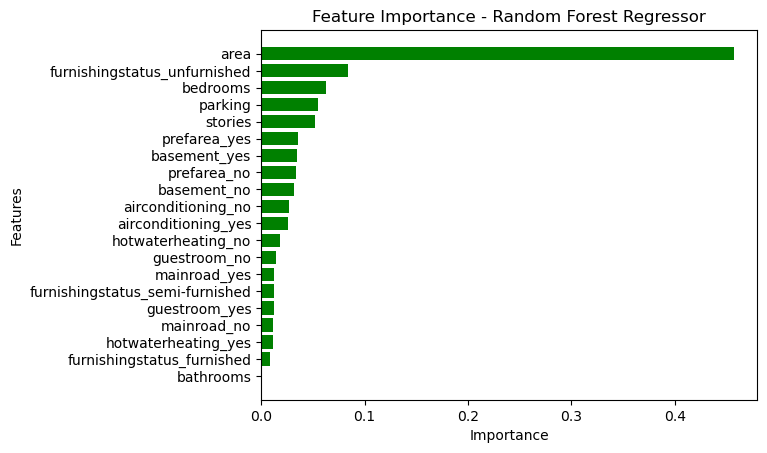

In [31]:
# Plotting feature importance
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest Regressor')
plt.gca().invert_yaxis();

'area' is the most important feature here that plays a very great role in the prediction 

# <center> Interactive Daskboard For Prediction 

In [32]:
from IPython.display import display, HTML
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

def make_prediction(area, bedrooms, bathrooms, stories, mainroad, guestroom,
                    basement, hotwaterheating, airconditioning, parking,
                    prefarea, furnishingstatus):
    # Creating a dictionary with the input data
    data = {
        "area": area,
        "bedrooms": bedrooms,
        "bathrooms": bathrooms,
        "stories": stories,
        "mainroad": mainroad,
        "guestroom": guestroom,
        "basement": basement,
        "hotwaterheating": hotwaterheating,
        "airconditioning": airconditioning,
        "parking": parking,
        "prefarea": prefarea,
        "furnishingstatus": furnishingstatus
    }
    
    df = pd.DataFrame(data, index=[0])
    
    # Perform prediction
    prediction = rf_model.predict(df).round(2)[0]
    output = f"<h>Predicted Apartment Price:</h> <h style='color: green;'><strong>${prediction}</strong></h>"
    display(HTML(output))

# Creating interactive sliders and dropdowns for user input
interact(
    make_prediction,
    area=FloatSlider(
        min=X_train["area"].min(),
        max=X_train["area"].max(),
        value=X_train["area"].mean(),
        description='Area (m²)',
    ),
    bedrooms=IntSlider(
        min=X_train["bedrooms"].min(),
        max=X_train["bedrooms"].max(),
        value=X_train["bedrooms"].mean(),
        description='Bedrooms',
    ),
    bathrooms=IntSlider(
        min=X_train["bathrooms"].min(),
        max=X_train["bathrooms"].max(),
        value=X_train["bathrooms"].mean(),
        description='Bathrooms',
    ),
    stories=IntSlider(
        min=X_train["stories"].min(),
        max=X_train["stories"].max(),
        value=X_train["stories"].mean(),
        description='Stories',
    ),
    mainroad=Dropdown(
        options=['yes', 'no'],
        value='yes',
        description='Main Road',
    ),
    guestroom=Dropdown(
        options=['yes', 'no'],
        value='no',
        description='Guest Room',
    ),
    basement=Dropdown(
        options=['yes', 'no'],
        value='no',
        description='Basement',
    ),
    hotwaterheating=Dropdown(
        options=['yes', 'no'],
        value='no',
        description='Hot Water Heating',
    ),
    airconditioning=Dropdown(
        options=['yes', 'no'],
        value='no',
        description='Air Conditioning',
    ),
    parking=IntSlider(
        min=X_train["parking"].min(),
        max=X_train["parking"].max(),
        value=X_train["parking"].mean(),
        description='Parking Spaces',
    ),
    prefarea=Dropdown(
        options=['yes', 'no'],
        value='yes',
        description='Preferred Area',
    ),
    furnishingstatus=Dropdown(
        options=['furnished', 'unfurnished'],
        value='furnished',
        description='Furnishing Status',
    )
);


interactive(children=(FloatSlider(value=4623.81095890411, description='Area (m²)', max=10360.0, min=1650.0), I…

#

This interactive tool above allows users to input various features of an apartment, such as area, number of bedrooms, and amenities like air conditioning and parking. Based on these inputs, the model predicts the apartment's price, providing a quick estimate to help users make informed decisions in the housing market